## Setup

In [98]:
cd /home/jake/Projects/mila/6759/cnn-downscaling/src/

/home/jake/Projects/mila/6759/cnn-downscaling/src


### Dependencies

In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns

import torch
import torch.nn.functional as F

from training.data import WeatherBenchSuperresolutionDataModule
from training.models import LitSuperresolutionModelWrapper

In [101]:
plt.style.use('seaborn-pastel')
sns.set_style("ticks")

### Arguments

In [102]:
best_ckpt = "/home/jake/Projects/mila/6759/cnn-downscaling/artifacts/checkpoints/dainty-spaceship-33/dainty-spaceship-33_best_val_loss_epoch=0261.ckpt"

In [103]:
DATA_DIR = "../data/processed/temp/"
COARSE_SUB_DIR = "5625/temp_5625_processed.zarr"  # 5.625 degrees
FINE_SUB_DIR = "1406/temp_1406_processed.zarr"  # 1.402 degrees

### Data

In [104]:
data_module = WeatherBenchSuperresolutionDataModule(
    coarse_dir = os.path.join(DATA_DIR, COARSE_SUB_DIR),
    fine_dir = os.path.join(DATA_DIR, FINE_SUB_DIR),
    batch_size = 2922  # length of validation set
)

data_module.setup(stage=None)

val_dataloader = data_module.val_dataloader()
coarse_validation, fine_validation = iter(val_dataloader).next()

del val_dataloader

### Best Checkpoint

In [105]:
model = LitSuperresolutionModelWrapper.load_from_checkpoint(best_ckpt)
model.eval()

LitSuperresolutionModelWrapper(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): Conv2d(5, 13, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): ReLU()
    (6): Conv2d(13, 55, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): Conv2d(55, 21, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): ReLU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1344, out_features=398, bias=True)
    (12): Linear(in_features=398, out_features=4096, bias=True)
    (13): Unflatten(dim=1, unflattened_size=(64, 64))
  )
  (loss): MSELoss()
)

### Generate Validation Set Predictions

In [106]:
preds_validation = model(coarse_validation)
preds_validation.shape

torch.Size([2922, 64, 64])

## Evaluation Metrics

In [107]:
torch.set_grad_enabled(False);

#### MSE

In [108]:
mse = F.mse_loss(preds_validation, fine_validation)
mse  # aligns with https://wandb.ai/6759-proj/cnn/runs/1uyqum0l

tensor(0.0075)

In [109]:
daily_mses = torch.mean((preds_validation - fine_validation)**2, dim=(1,2))
torch.mean(daily_mses)  # reproduces what's on W&B

tensor(0.0075)

#### Correlation

In [110]:
pred_demeaned = (preds_validation - preds_validation.mean(axis=(1,2), keepdims=True))
true_demeaned = (fine_validation - fine_validation.mean(axis=(1,2), keepdims=True))

daily_corrs = \
    torch.sum(pred_demeaned*true_demeaned, axis=(1,2)) / \
    (torch.sqrt(torch.sum(pred_demeaned ** 2, axis=(1,2))) * torch.sqrt(torch.sum(true_demeaned ** 2, axis=(1,2))))

del pred_demeaned, true_demeaned

print(daily_corrs.min(), daily_corrs.mean(), daily_corrs.max())

tensor(0.9901) tensor(0.9960) tensor(0.9984)


#### Bias

In [111]:
train_dates, val_dates, test_dates = data_module.split_date_ranges

In [112]:
validation_pdf = pd.DataFrame(
    fine_validation.flatten(),
    index=data_module.fine.loc[val_dates[0]:val_dates[-1]].index,
    columns=["temp_true"]
)
validation_pdf["temp_pred"] = preds_validation.flatten()

In [115]:
validation_pdf_unscaled = \
    validation_pdf.join(data_module.daily_means).join(data_module.daily_std)

validation_pdf_unscaled['temp_true'] = \
    validation_pdf_unscaled['temp_true'] * validation_pdf_unscaled['std'] + \
    validation_pdf_unscaled['mean']

validation_pdf_unscaled['temp_pred'] = \
    validation_pdf_unscaled['temp_pred'] * validation_pdf_unscaled['std'] + \
    validation_pdf_unscaled['mean']

del validation_pdf_unscaled['mean']
del validation_pdf_unscaled['std']

In [117]:
def q02(ser):
    return ser.quantile(.02)

def q98(ser):
    return ser.quantile(.98)

validation_biases = validation_pdf_unscaled.groupby(
    [validation_pdf_unscaled.index.get_level_values("date")]
).agg(['mean', q02, q98])

In [118]:
validation_biases

temp_true                       temp_pred                      
                mean        q02        q98      mean        q02        q98
date                                                                      
2007-01-01  6.702885 -26.132439  31.097370  6.804111 -25.657387  31.242256
2007-01-02  6.865813 -27.354398  30.907260  6.972022 -26.585099  30.956605
2007-01-03  6.738414 -28.436897  30.923721  6.770273 -27.764479  30.853545
2007-01-04  6.506089 -31.042441  30.406405  6.659351 -30.127551  30.195593
2007-01-05  5.981996 -33.173791  30.544155  6.035810 -33.184425  30.362122
...              ...        ...        ...       ...        ...        ...
2014-12-27  5.030199 -34.069731  31.819334  5.193396 -32.677536  31.396847
2014-12-28  4.602593 -32.040288  31.591561  4.772549 -31.418096  31.580416
2014-12-29  4.044850 -33.180261  31.073019  4.097613 -32.157833  31.115526
2014-12-30  3.905563 -33.042085  31.633780  3.988840 -32.870114  30.964669
2014-12-31  3.685791 -32.086592  31.357232  3.784436 -30.962875  30.624423

[2922 rows x 6 columns]

In [123]:
validation_biases['bias_mean'] = validation_biases['temp_true']['mean'] - validation_biases['temp_pred']['mean']
validation_biases['bias_q02'] = validation_biases['temp_true']['q02'] - validation_biases['temp_pred']['q02']
validation_biases['bias_q98'] = validation_biases['temp_true']['q98'] - validation_biases['temp_pred']['q98']

#### TXx, TXn (Monthly)

In [124]:
validation_tx = validation_pdf_unscaled.groupby(
    [validation_pdf.index.get_level_values("date").to_period('M'), "lat", "lon"]
).agg({
    "temp_true": [np.max, np.min],
    "temp_pred": [np.max, np.min],
})

validation_tx.columns = ["true_txx", "true_txn", "pred_txx", "pred_txn"]

In [126]:
validation_tx["bias_txx"] = validation_tx["pred_txx"] - validation_tx["true_txx"]
validation_tx["bias_txn"] = validation_tx["pred_txn"] - validation_tx["true_txn"]

#### Stability

In [127]:
preds_std = torch.std(preds_validation, dim=(1,2))
fine_std = torch.std(fine_validation, dim=(1,2))

In [128]:
daily_stability = preds_std / fine_std

## Evaluation Analysis

### Aggregate Daily Results

In [129]:
train_dates, val_dates, test_dates = data_module.split_date_ranges

In [131]:
eval_metrics = pd.DataFrame(
    {
        'mse' : daily_mses,
        'corr' : daily_corrs,
        'bias_p02' : validation_biases['bias_q02'],
        'bias_mean' : validation_biases['bias_mean'],
        'bias_p98' : validation_biases['bias_q98'],
        'stability' : daily_stability,
    },
    index = val_dates
)

In [132]:
eval_metrics.head(3)

,mse,corr,bias_p02,bias_mean,bias_p98,stability
date,,,,,,
2007-01-01,0.004725,0.997298,-0.475053,-0.101225,-0.144886,0.997805
2007-01-02,0.004892,0.997208,-0.769299,-0.106209,-0.049345,0.997789
2007-01-03,0.005081,0.997129,-0.672417,-0.031859,0.070176,0.999211


### Error Distribution

In [133]:
shared_line_kwargs = {"alpha": .67, "linestyle": "dashed", "linewidth": 2}
pctiles_extremes = [.02, .05, .1, .5, .9, .95, .98]

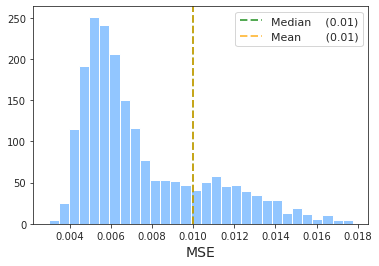

In [134]:
ax = eval_metrics['mse'].hist(bins=30, density=True, figsize=(6,4));

summary = eval_metrics['mse'].describe(percentiles=[]).round(2)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("MSE", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

#### Daily Bias Distributions

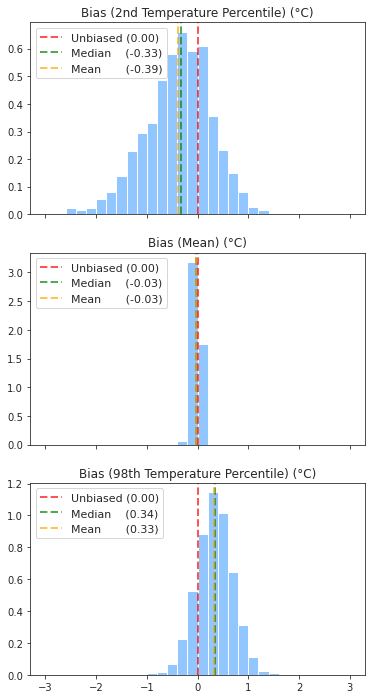

In [135]:
fig, axes =  plt.subplots(3, 1, figsize=(6,12), sharex=True)

measure_and_column = zip(
    [f"Bias ({loc}) (°C)" for loc in ["2nd Temperature Percentile", "Mean", "98th Temperature Percentile"]],
    ['bias_p02', 'bias_mean', 'bias_p98']
)

for i, (measure, col) in enumerate(measure_and_column):
    axes[i].hist(eval_metrics[col], range=(-3,3), bins=30, density=True, label=None)

    # summary statistics
    summary = eval_metrics[col].describe(percentiles=[]).round(2)
    axes[i].axvline(0, color="red", label="Unbiased (0.00)", **shared_line_kwargs)
    axes[i].axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
    axes[i].axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

    # labels
    axes[i].set_title(measure)
    axes[i].legend(loc="upper left", fontsize=11)

### Stability Distribution

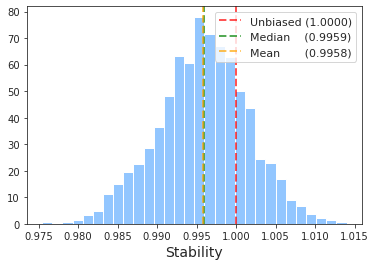

In [139]:
ax = eval_metrics['stability'].hist(bins=30, density=True, figsize=(6,4));

summary = eval_metrics['stability'].describe(percentiles=[]).round(4)
ax.axvline(1, color="red", label="Unbiased (1.0000)", **shared_line_kwargs)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("Stability", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

### Monthly TXx, TXn Bias
#### Distribution
_each contribution is a calendar month (`yyyy-mm`)_

count    393216.00
mean         -0.33
std           1.15
min         -16.83
2%           -3.20
5%           -2.34
10%          -1.67
50%          -0.23
90%           0.83
95%           1.32
98%           2.00
max          13.46
Name: bias_txx, dtype: float64


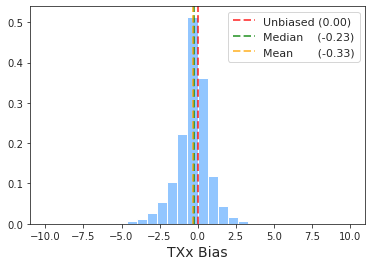

In [142]:
ax = validation_tx["bias_txx"].hist(bins=30, range=(-10,10), density=True, figsize=(6,4));

summary = validation_tx["bias_txx"].describe(percentiles=pctiles_extremes).round(2)
ax.axvline(0, color="red", label="Unbiased (0.00)", **shared_line_kwargs)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("TXx Bias", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

print(summary)

count    393216.00
mean          0.58
std           1.29
min          -9.18
2%           -2.01
5%           -1.26
10%          -0.71
50%           0.43
90%           2.14
95%           2.93
98%           3.91
max          14.49
Name: bias_txn, dtype: float64


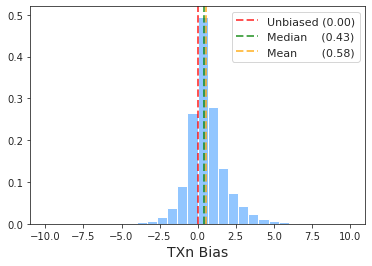

In [143]:
ax = validation_tx["bias_txn"].hist(bins=30, range=(-10,10), density=True, figsize=(6,4));

summary = validation_tx["bias_txn"].describe(percentiles=pctiles_extremes).round(2)
ax.axvline(0, color="red", label="Unbiased (0.00)", **shared_line_kwargs)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("TXn Bias", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

print(summary)

#### By Month

In [144]:
tx_avg_bias_by_month = validation_tx[["bias_txn", "bias_txx"]].groupby(
    validation_tx.index.get_level_values("date").month
).agg({
    "bias_txn": [np.mean, np.std],
    "bias_txx": [np.mean, np.std],
})

tx_avg_bias_by_month.columns = ["bias_txn_mean", "bias_txn_std", "bias_txx_mean", "bias_txx_std"]

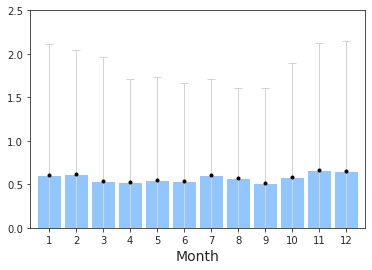

In [145]:
ax = tx_avg_bias_by_month["bias_txn_mean"].plot.bar(figsize=(6,4), width=.9);
plt.errorbar(
    x = list(range(0,11+1)),
    y = tx_avg_bias_by_month["bias_txn_mean"],
    yerr = tx_avg_bias_by_month["bias_txn_std"],
    fmt = ".k", ecolor='lightgray', elinewidth=1, capsize=4
);

plt.ylim(0,2.5);
plt.xticks(rotation=0);
ax.set_xlabel("Month", fontsize=14);

#### Average by Geography

In [146]:
tx_avg_bias_by_geo = validation_tx.groupby(["lat", "lon"])[["bias_txx", "bias_txn"]].mean()

In [147]:
latitudes = data_module.fine.index.levels[1].to_series()
longitudes = data_module.fine.index.levels[2].to_series()

m = Basemap(projection='ortho', lat_0=30 ,lon_0=-100, resolution='l')
x, y = m(*np.meshgrid(longitudes-180,latitudes))

Charts below indicate a slight tendency for the superresolution CNN to capture temperature maximums (TXx) in South America. This makes sense because the patterns learned in North America likely do not apply in the South.

More notably, we can see the CNN's tendency to on average _under_estimate minimum monthly temperatures (TXn) across the full geography. 

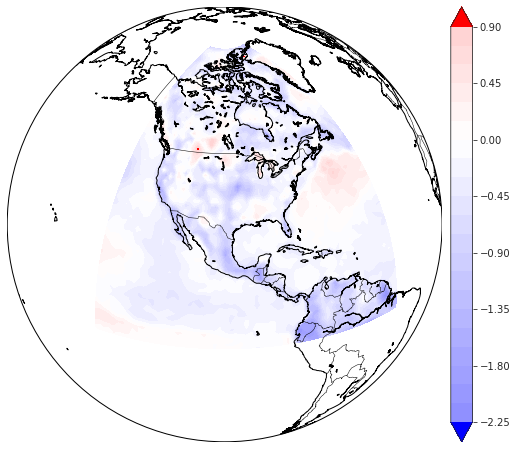

In [148]:
cs = m.contourf(
    x, y,
    tx_avg_bias_by_geo["bias_txx"].unstack("lon").values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-5, vmax=5, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

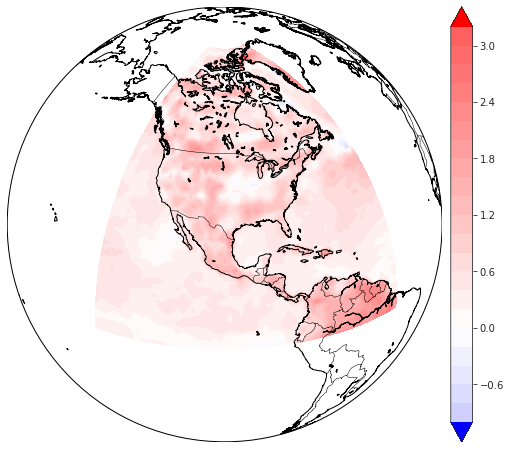

In [149]:
cs = m.contourf(
    x, y,
    tx_avg_bias_by_geo["bias_txn"].unstack("lon").values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-5, vmax=5, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

### Worst Errors Analysis

In [155]:
validation_pdf_unscaled['error'] = (validation_pdf_unscaled["temp_pred"]-validation_pdf_unscaled["temp_true"])
validation_pdf_unscaled['squared_error'] = validation_pdf_unscaled['error']**2

#### Summary

In [157]:
pctiles_extremes = [.02, .05, .1, .5, .9, .95, .98]
summary = eval_metrics['mse'].describe(percentiles=pctiles_extremes)
summary

count    2922.000000
mean        0.007508
std         0.003035
min         0.002968
2%          0.004030
5%          0.004297
10%         0.004620
50%         0.006368
90%         0.012340
95%         0.013781
98%         0.015180
max         0.017764
Name: mse, dtype: float64

In [158]:
bad_days = eval_metrics[eval_metrics['mse'] >= summary["95%"]]
bad_days_geo = validation_pdf_unscaled.loc[bad_days.index]

#### By Month

interesting: bad days have flipped from all winter months in the first round to all summer months in this round

In [160]:
bad_days_by_month = bad_days_geo.groupby(
    bad_days_geo.index.get_level_values("date").month
).size()

bad_days_by_month  # only winter months!

date
6    155648
7    380928
8     65536
dtype: int64

#### Squared Error by Geography

In [161]:
avg_mse_by_coord = validation_pdf_unscaled['squared_error'].groupby(["lat","lon"]).mean()

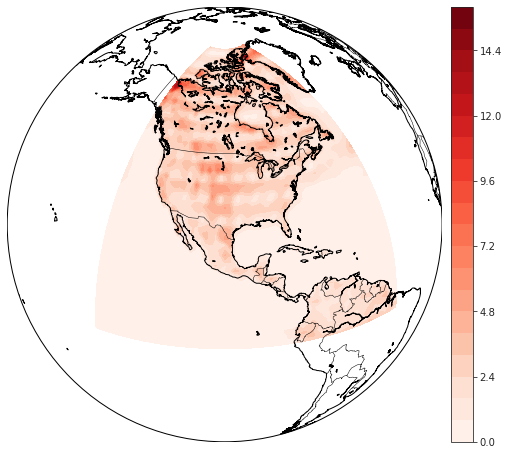

In [162]:
cs = m.contourf(
    x, y,
    avg_mse_by_coord.unstack("lon").values,
    levels=24, alpha=1,
    cmap = 'Reds'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

#### Error by Geography

In [163]:
avg_bad_days_error_by_geo = bad_days_geo["error"].groupby(["lat","lon"]).mean()

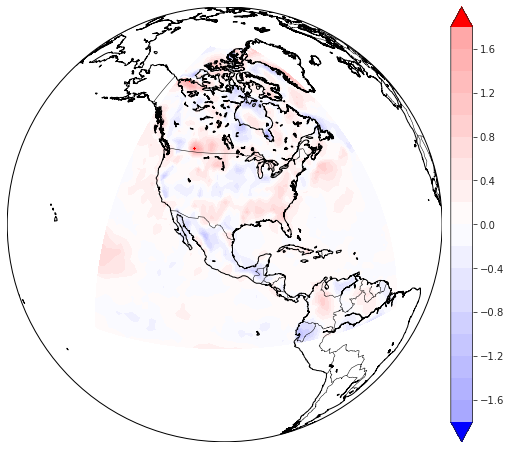

In [164]:
cs = m.contourf(
    x, y,
    avg_bad_days_error_by_geo.unstack("lon").values,
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-5, vmax=5, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

#### Random Worst Samples

2012-06-18 00:00:00


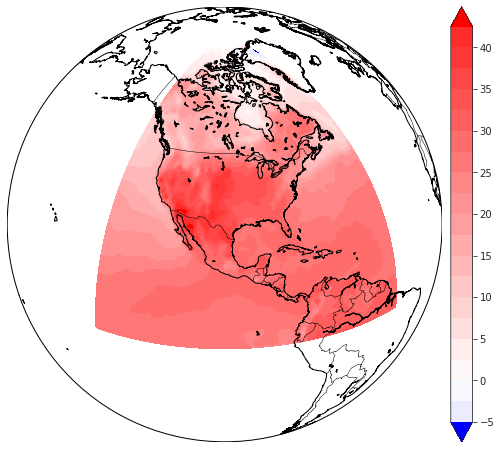

In [165]:
rdate = bad_days.index.to_series().sample(random_state=1).iloc[0]
print(rdate)

cs = m.contourf(
    x, y,
    bad_days_geo['temp_true'].loc[rdate].unstack("lon").values,
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

2011-07-15 00:00:00


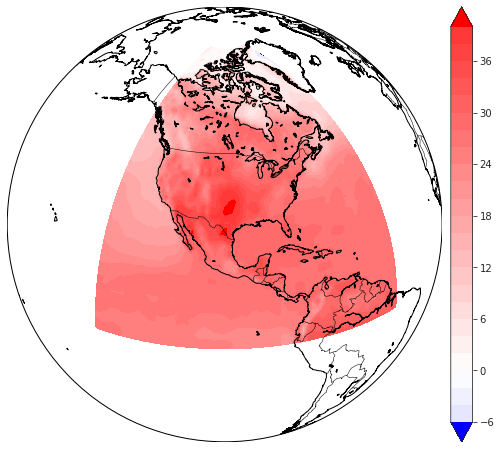

In [166]:
rdate = bad_days.index.to_series().sample(random_state=2).iloc[0]
print(rdate)

cs = m.contourf(
    x, y,
    bad_days_geo['temp_true'].loc[rdate].unstack("lon").values,
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

2008-07-08 00:00:00


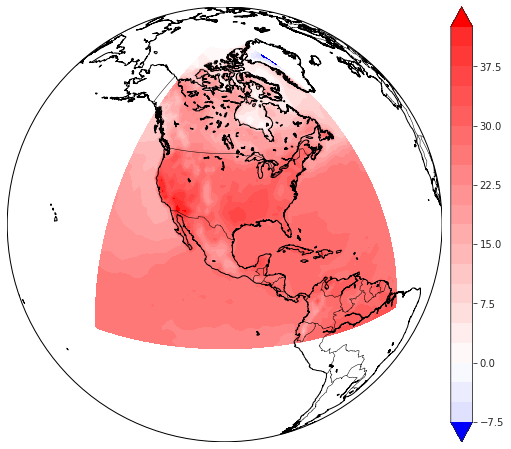

In [167]:
rdate = bad_days.index.to_series().sample(random_state=3).iloc[0]
print(rdate)

cs = m.contourf(
    x, y,
    bad_days_geo['temp_true'].loc[rdate].unstack("lon").values,
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

2013-07-28 00:00:00


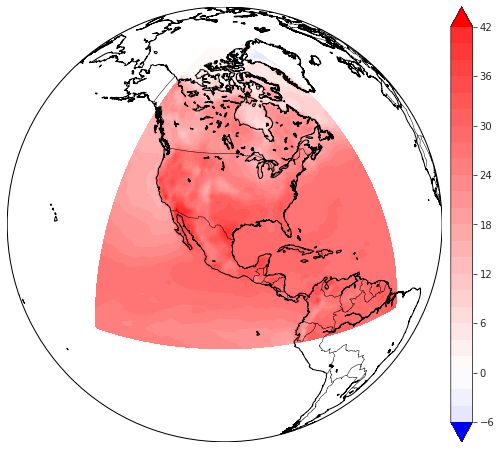

In [168]:
rdate = bad_days.index.to_series().sample(random_state=4).iloc[0]
print(rdate)

cs = m.contourf(
    x, y,
    bad_days_geo['temp_true'].loc[rdate].unstack("lon").values,
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

2013-06-11 00:00:00


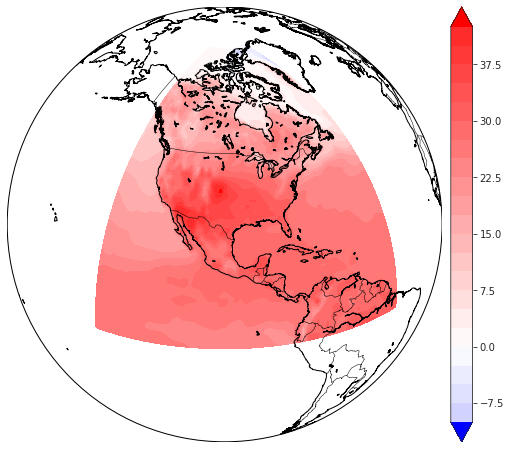

In [169]:
rdate = bad_days.index.to_series().sample(random_state=5).iloc[0]
print(rdate)

cs = m.contourf(
    x, y,
    bad_days_geo['temp_true'].loc[rdate].unstack("lon").values,
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

#### by Variance

this analysis now indicates that the scaling issue was solved

In [170]:
stdev = validation_pdf["temp_true"].groupby("date").std()
mse = validation_pdf["squared_error"].groupby("date").std()

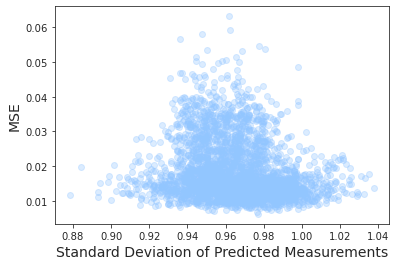

In [171]:
fig = plt.scatter(x=stdev, y=mse, alpha=.33);
plt.gcf().set_size_inches(6,4);
plt.xlabel("Standard Deviation of Predicted Measurements", fontsize=14);
plt.ylabel("MSE", fontsize=14);